<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/parameter_estimation/parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [93]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd  
import sys
from scipy.integrate import odeint
from time import time as clock

In [96]:
# In order to access the package you need to have its path. The path required is the path WHERE that package is soterd, not it path
# sys.path.insert(1, 'd:\\DYNAMICAL SIMULATION\\maestria\\maestria')

In [97]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 292 (delta 40), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (292/292), 9.06 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [98]:
cd maestria

/content/maestria/maestria/maestria


In [99]:
import utilis.functions as fn
from utilis.models import monod_model

In [154]:
# Definir parametros 
mu_max = 1.2 # g/L
yxs = 0.2 
ks = 280 # g/L
ypx = 4 

In [155]:
# Definir condiciones iniciales 
x0 = np.array([0.2, 40, 0])
# Definir tiempo de integracion 
tf = 60 
dt = 1 
time = np.arange(0, tf+dt, dt)
# Simular ODEs
x, s, p = odeint(monod_model, x0, time, args =(0, mu_max, yxs, ks, ypx,)).T

In [156]:
fn.final_conc(x, s, p)

(8.185126166432566, 0.07436916783716456, 31.94050466573027)

In [157]:
predicted = fn.create_df(time, x, s, p)
predicted.head()

,t,x,s,p
0,0,0.200000,40.000000,0.000000
1,1,0.232307,39.838466,0.129227
2,2,0.269678,39.651610,0.278712
3,3,0.312854,39.435728,0.451417
4,4,0.362666,39.186670,0.650664


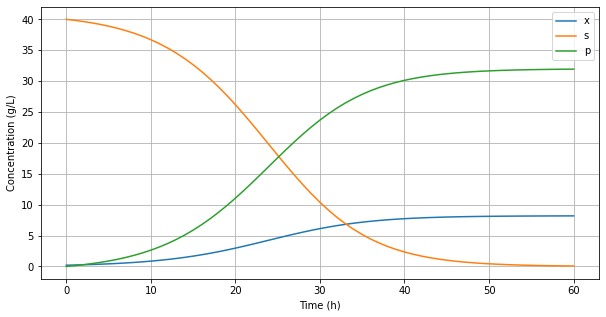

In [158]:
fn.plot_data(predicted)

In [159]:
predicted_noise = fn.add_noise(predicted, 0.1, 1, 1)

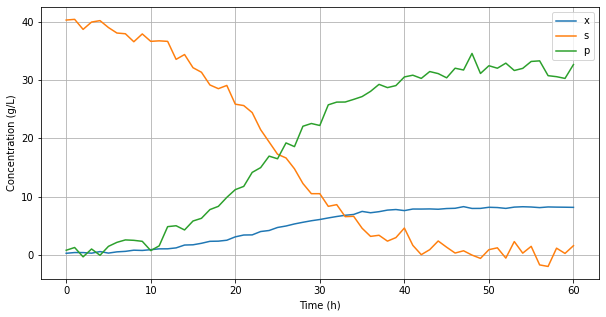

In [160]:
fn.plot_data(predicted_noise)

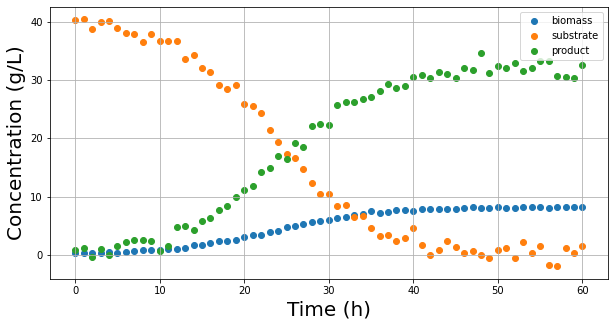

In [161]:
plt.figure(figsize=(10, 5))
plt.scatter(predicted_noise.t, predicted_noise.x, label = 'biomass')
plt.scatter(predicted_noise.t, predicted_noise.s, label = 'substrate')
plt.scatter(predicted_noise.t, predicted_noise.p, label = 'product')
plt.xlabel("Time (h)", size = 20)
plt.ylabel('Concentration (g/L)', size = 20)
plt.grid()
plt.legend(fontsize=10)
plt.show()

In [162]:
def fitness_function(parms):
    mu_max, yxs, ks, ypx = parms
    x, s, p =  odeint(monod_model, x0, time, args =(0, mu_max, yxs, ks, ypx,)).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(predicted_noise, out)

In [163]:
fitness_function([mu_max, yxs, ks, ypx])

1.7105443241570482

In [164]:
# Configuramos algoritmo genetico
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':50,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.8,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

In [165]:
# Establecer los rangos de busqueda para las variables de decision
varbound=np.array([
    [0,3], # mu_max
    [0,1], # yxs
    [100,300], # ks
    [0,10] # ypx
])

In [166]:
# LLamar el algortimo genetico para realizar la optimizacion
model=ga(function=fitness_function,
         dimension=4,
         variable_type='real',
         variable_boundaries=varbound,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [9.45871393e-01 1.42627213e-01 2.35815652e+02 5.66016009e+00]

 Objective function:
 4.775115162030302


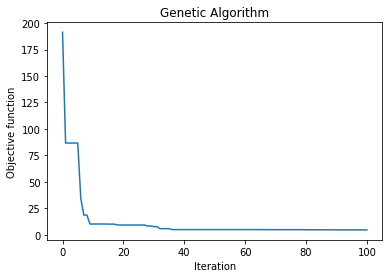

In [169]:
# Realizar la busqueda
start_time = clock()
model.run()
end_time = clock()

In [170]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 13.142s


In [171]:
print("Minimun fitness value:")
print(model.best_function)

Minimun fitness value:
4.775115162030302


In [172]:
print('Best solution found:')
print("mu_max: ",round(model.best_variable[0], 2))
print("yxs: ",round(model.best_variable[1], 2))
print("ks: ",round(model.best_variable[2], 2))
print("ypx: ",round(model.best_variable[3], 2))

Best solution found:
mu_max:  0.95
yxs:  0.14
ks:  235.82
ypx:  5.66


mu_max = 1.2  g/L

yxs = 0.2 

ks = 280  g/L

ypx = 4 